The overall plan of this code is to create a model that deduces the daily AQI (air quality index) based on the number of cars without measuring the air composition.
For that, a column named AQI will firstly be added to the fulldata_daily dataframe.
Using this dataframe, different algorithms along with crossvalidation will be tried to create a model that classifies the observed data into correct AQI, only based on the number of cars data.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('../processed_data/full_data_imputed.csv') #you have implemented here not the imputed data rather the full_data, which was not cleaned
df.head()

,Jahr,Monat,Tag,Zeit,Datum,Zweirad,Personenwagen,Lastwagen,Hr,RainDur,...,WVs,StrGlo,p,NO2,NO,NOx,O3,CO,PM10,SO2
0,2007,1,1,00:00,2007-01-01T00:00,6,66,0,65.26,0.00,...,3.79,1.48,975.65,19.80,1.70,11.71,45.31,0.30,53.27,7.88
1,2007,1,1,01:00,2007-01-01T01:00,33,232,6,68.60,5.63,...,5.27,1.50,974.98,13.26,2.88,9.24,54.38,0.27,27.84,3.21
2,2007,1,1,02:00,2007-01-01T02:00,30,228,6,73.04,26.47,...,4.40,1.51,974.43,14.07,1.95,8.92,52.51,0.26,13.06,3.01
3,2007,1,1,03:00,2007-01-01T03:00,24,229,6,78.79,57.95,...,4.11,1.49,973.78,12.26,1.69,7.77,53.81,0.24,10.81,2.97
4,2007,1,1,04:00,2007-01-01T04:00,21,208,7,83.82,41.25,...,2.82,1.48,973.30,32.60,4.90,20.98,25.57,0.33,25.29,3.71


EAQI classifies the stations as 'Traffic stations' or 'Industrial and Background stations'. Stampfenbachstrasse is classified as traffic stations and for traffic stations, only NO2, PM10, PM2.5 are considered to calculate EAQI.
Since our dataset doesn't have PM2.5 we only use NO2 and PM10 to calculate the EAQI.

In [3]:
# Leave out only the variables that I need
#df = df.iloc[:,[0,1,2,3,4,5,6,7,14,19]]
#df.head()

In [4]:
#df = df.dropna(subset = ['Zweirad', 'Personenwagen', 'Lastwagen'])

In [4]:
# For NO2, O3, SO2, hourly concentrations are fed into the calculation of index
# For PM10, PM2.5, the 24-hour running means for the past 24 hours are used. (minum of 18 hours needed)

df['PM10_calc'] = df['PM10'].rolling(window=24, min_periods=18).mean()
df

,Jahr,Monat,Tag,Zeit,Datum,Zweirad,Personenwagen,Lastwagen,Hr,RainDur,...,StrGlo,p,NO2,NO,NOx,O3,CO,PM10,SO2,PM10_calc
0,2007,1,1,00:00,2007-01-01T00:00,6,66,0,65.26,0.00,...,1.48,975.65,19.80,1.70,11.71,45.31,0.30,53.27,7.88,NaN
1,2007,1,1,01:00,2007-01-01T01:00,33,232,6,68.60,5.63,...,1.50,974.98,13.26,2.88,9.24,54.38,0.27,27.84,3.21,NaN
2,2007,1,1,02:00,2007-01-01T02:00,30,228,6,73.04,26.47,...,1.51,974.43,14.07,1.95,8.92,52.51,0.26,13.06,3.01,NaN
3,2007,1,1,03:00,2007-01-01T03:00,24,229,6,78.79,57.95,...,1.49,973.78,12.26,1.69,7.77,53.81,0.24,10.81,2.97,NaN
4,2007,1,1,04:00,2007-01-01T04:00,21,208,7,83.82,41.25,...,1.48,973.30,32.60,4.90,20.98,25.57,0.33,25.29,3.71,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128438,2021,12,31,17:00,2021-12-31T17:00,47,263,9,71.37,0.00,...,0.02,974.52,43.06,23.13,41.06,5.15,0.44,11.75,0.95,9.630000
128439,2021,12,31,18:00,2021-12-31T18:00,38,231,8,74.19,0.00,...,0.02,975.30,41.24,16.01,34.40,5.82,0.44,11.64,1.05,9.720833
128440,2021,12,31,19:00,2021-12-31T19:00,42,237,9,76.60,0.00,...,0.02,976.00,41.26,27.80,43.86,5.07,0.41,17.14,1.20,10.070833
128441,2021,12,31,20:00,2021-12-31T20:00,37,211,8,77.54,0.00,...,0.02,976.24,39.77,26.21,41.81,3.64,0.42,19.24,1.23,10.376667


In [5]:
# integrating concentration and index levels according to the EAQI table

range_PM10 = [0, 20, 40, 50, 100, 150, 1200]
range_NO2 = [0, 40, 90, 120, 230, 340, 1000]

# by setting labels=False, AQI will be expressed as integers.
# 0:Good, 1:Fair, 2:Moderate, 3:Poor, 4:VeryPoor, 5:ExtremlyPoor

NO2_bins = pd.cut(df['NO2'], bins=range_NO2, labels=False, include_lowest=True)
df['NO2_AQI'] = NO2_bins

PM10_bins = pd.cut(df['PM10_calc'], bins=range_PM10, labels=False, include_lowest=True)
df['PM10_AQI'] = PM10_bins

# The AQI corresponds to the poorest of any pollutant considered
df['AQI'] = np.fmax(df['NO2_AQI'], df['PM10_AQI'])
df = df.dropna(subset=['AQI'])


df.to_csv('../processed_data/full_data_imputed_with_EAQI.csv', index=False, float_format='%.3f')
df

,Jahr,Monat,Tag,Zeit,Datum,Zweirad,Personenwagen,Lastwagen,Hr,RainDur,...,NO,NOx,O3,CO,PM10,SO2,PM10_calc,NO2_AQI,PM10_AQI,AQI
0,2007,1,1,00:00,2007-01-01T00:00,6,66,0,65.26,0.00,...,1.70,11.71,45.31,0.30,53.27,7.88,NaN,0,NaN,0.0
1,2007,1,1,01:00,2007-01-01T01:00,33,232,6,68.60,5.63,...,2.88,9.24,54.38,0.27,27.84,3.21,NaN,0,NaN,0.0
2,2007,1,1,02:00,2007-01-01T02:00,30,228,6,73.04,26.47,...,1.95,8.92,52.51,0.26,13.06,3.01,NaN,0,NaN,0.0
3,2007,1,1,03:00,2007-01-01T03:00,24,229,6,78.79,57.95,...,1.69,7.77,53.81,0.24,10.81,2.97,NaN,0,NaN,0.0
4,2007,1,1,04:00,2007-01-01T04:00,21,208,7,83.82,41.25,...,4.90,20.98,25.57,0.33,25.29,3.71,NaN,0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128438,2021,12,31,17:00,2021-12-31T17:00,47,263,9,71.37,0.00,...,23.13,41.06,5.15,0.44,11.75,0.95,9.630000,1,0.0,1.0
128439,2021,12,31,18:00,2021-12-31T18:00,38,231,8,74.19,0.00,...,16.01,34.40,5.82,0.44,11.64,1.05,9.720833,1,0.0,1.0
128440,2021,12,31,19:00,2021-12-31T19:00,42,237,9,76.60,0.00,...,27.80,43.86,5.07,0.41,17.14,1.20,10.070833,1,0.0,1.0
128441,2021,12,31,20:00,2021-12-31T20:00,37,211,8,77.54,0.00,...,26.21,41.81,3.64,0.42,19.24,1.23,10.376667,0,0.0,0.0


In [6]:
print(df['AQI'].value_counts())
# Since we have a very unbalanced dataset where there are a lot of 0 ('Good') AQIs, we perform stratified K-fold cross validation

from sklearn.model_selection import StratifiedKFold

0.0    67398
1.0    53668
2.0     4510
3.0     2866
4.0        1
Name: AQI, dtype: int64


Now with the hourly vehicles and AQI data, we can perform classification algorithms.
Starting with K-nearest neighbor

In [7]:
# K-nearest neighbors <- This will be done in the classification_air_quality.py

from sklearn.model_selection import train_test_split

tr_data, vali_data, tr_label, vali_label = train_test_split(df[['Personenwagen','Lastwagen']], df['AQI'], random_state=100)

print(len(tr_data))
print(len(vali_data))
print(len(tr_label))
print(len(vali_label))

96332
32111
96332
32111


In [10]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=250)
classifier.fit(tr_data, tr_label)

KNeighborsClassifier(n_neighbors=250)

In [11]:
print(classifier.score(tr_data, tr_label))
print(classifier.score(vali_data, vali_label))

0.5709006353029108
0.5638254803649839


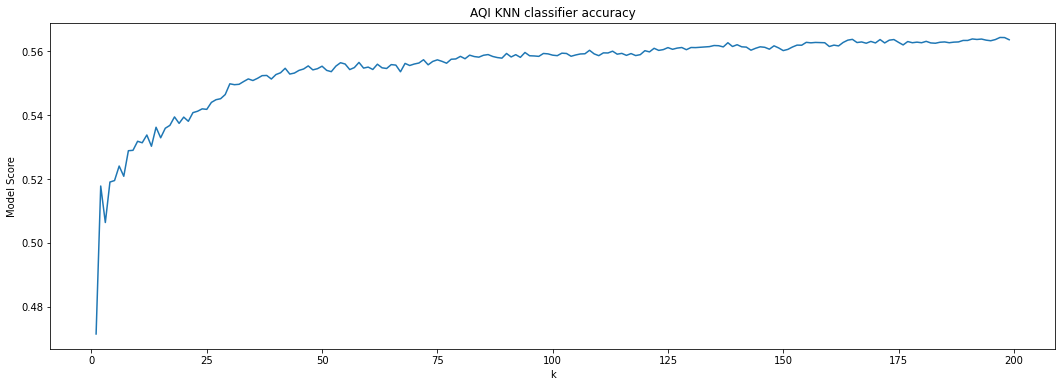

In [9]:
k_list = range(1,200)
accuracies = []

for k in k_list:
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(tr_data, tr_label)
    accuracies.append(classifier.score(vali_data, vali_label))

plt.figure(figsize=(18,6))
plt.plot(k_list, accuracies)
plt.xlabel('k')
plt.ylabel('Model Score')
plt.title('AQI KNN classifier accuracy')
plt.show()

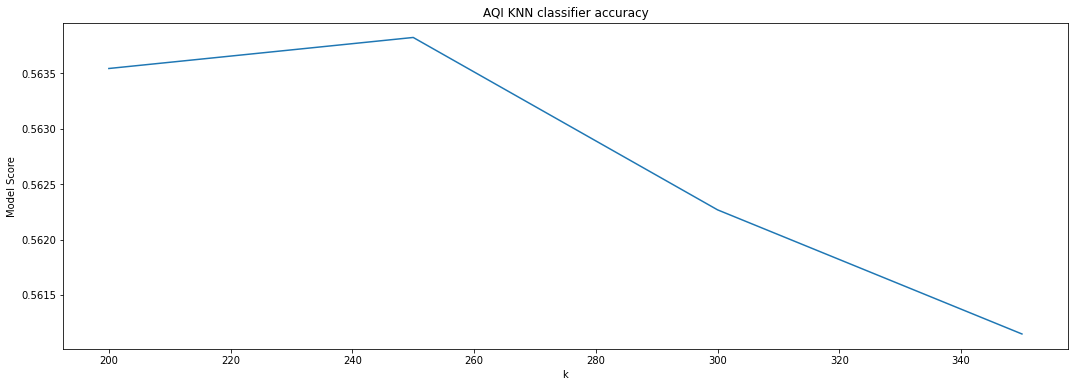

In [9]:
k_ls = list(range(200, 400, 50))
score = []

for k in k_ls:
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(tr_data, tr_label)
    score.append(classifier.score(vali_data, vali_label))

plt.figure(figsize=(18,6))
plt.plot(k_ls, score)
plt.xlabel('k')
plt.ylabel('Model Score')
plt.title('AQI KNN classifier accuracy')
plt.show()

In [13]:
X = df[['Personenwagen', 'Lastwagen']]
y = df['AQI']

In [12]:
from sklearn.model_selection import cross_val_score, cross_validate

cv_score = cross_val_score(classifier, X, y, scoring='accuracy', cv=5)
print('Cross validation score : {}'.format(np.round(cv_score, 4)))
print('Average score : {}'.format(np.mean(cv_score)))

result = cross_validate(classifier, X, y, scoring='accuracy', cv=5, return_train_score=True)
print('Each validation results : \n', pd.DataFrame(result))


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross validation score : [0.5301 0.5231 0.561  0.5308 0.5537]
Average score : 0.5397414030454284


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Each validation results : 
    fit_time  score_time  test_score  train_score
0  0.040742    1.739620    0.530110     0.578440
1  0.043482    1.744999    0.523103     0.579462
2  0.041762    2.033364    0.560979     0.570284
3  0.042090    1.736978    0.530793     0.568362
4  0.038671    1.544091    0.553722     0.567622


In [17]:
# This shit is not working
#from sklearn.model_selection import StratifiedKFold

#skf = StratifiedKFold(n_splits=5)
#skf.get_n_splits(X, y)

#for train_index, test_index in skf.split(X, y):
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


KeyError: "None of [Int64Index([  9248,   9538,   9539,   9540,   9541,   9542,   9543,   9544,\n              9545,   9546,\n            ...\n            128433, 128434, 128435, 128436, 128437, 128438, 128439, 128440,\n            128441, 128442],\n           dtype='int64', length=102754)] are in the [columns]"

Maybe we can get the best parameter using the 'GridSearchCV' function and change the explanatory valiables to see what produces the best score.